#[실습] XGBoost using Python wrapper
- breast cancer dataset(위스콘신 유방암 데이터) : 종양의 크기 , 모양 등 다양한 속성값으로 악성종양(malignant) 인지 양성종양(benign)인지 분류한 데이터 
- 종양의 다양한 피처에 따라 악성종양인지 일반 양성 종양인지를 XGBoost를 이용해 예측해보자
- 정확도 : 0.956 

## 1. Data import and Check dataset
 - python wrapper xgboost 의 경우, DMatrix로 형태 변경

In [39]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore') 

def get_clf_eval(y_test, preds, pred_probs):
    mat = confusion_matrix(y_test,preds)
    acc = accuracy_score(y_test,preds)
    precision = precision_score(y_test,preds)
    recall = recall_score(y_test,preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test,preds)
    print('오차행렬 \n{}  \n정확도 : {:.3f} 정밀도 :{:.3f} 재현율 :{:.3f} f1 :{:.3f} auc:{:.3f}'.format(mat, acc,precision, recall,f1,auc))

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features,columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [40]:
# 0 : mailgnant / 1 : benign
print('target info : ', dataset.target_names)
print(cancer_df['target'].value_counts())

target info :  ['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [41]:
# test dataset 20% / train dataset 80%
X_train, X_test, y_train, y_test= train_test_split(X_features, y_label, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


In [42]:
# python wrapper xgboost 의 경우, DMatrix를 이용한다.
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
print(type(dtrain), type(dtest))

<class 'xgboost.core.DMatrix'> <class 'xgboost.core.DMatrix'>


##2. xgb 학습후 예측
-  train으로 학습시 train - error , eval-logloss는 지속적으로 감소한다.
-  predict결과값은 확률값으로 나옴
- 정확도 : 0.956 정밀도 :0.985 재현율 :0.943 f1 :0.964 auc:0.960

In [43]:
params = {
    'max_depth' : 3,
    'eta' : 0.1,
    'objective'  : 'binary:logistic', # target이 0,1 이진분류이므로 binary logistic
    'eval_metric' :'logloss', 
    'early stopping':500 
}

num_rounds = 1000 # 부스팅 반복횟수는 400회

# train dataset은 'train' evaluation test dataset은 'eval'로 표기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain =dtrain , num_boost_round=num_rounds, early_stopping_rounds=500, evals=wlist)

[0]	train-logloss:0.609571	eval-logloss:0.612011
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 500 rounds.
[1]	train-logloss:0.541411	eval-logloss:0.549438
[2]	train-logloss:0.483286	eval-logloss:0.495781
[3]	train-logloss:0.435568	eval-logloss:0.448049
[4]	train-logloss:0.392154	eval-logloss:0.411764
[5]	train-logloss:0.353474	eval-logloss:0.376427
[6]	train-logloss:0.3209	eval-logloss:0.349805
[7]	train-logloss:0.292539	eval-logloss:0.322584
[8]	train-logloss:0.266347	eval-logloss:0.298739
[9]	train-logloss:0.243992	eval-logloss:0.280988
[10]	train-logloss:0.224376	eval-logloss:0.262922
[11]	train-logloss:0.205832	eval-logloss:0.247066
[12]	train-logloss:0.189968	eval-logloss:0.234151
[13]	train-logloss:0.176058	eval-logloss:0.221007
[14]	train-logloss:0.162803	eval-logloss:0.210084
[15]	train-logloss:0.151687	eval-logloss:0.199908
[16]	train-logloss:0.141012	eval-logloss:0.191516
[17]	train-l

In [44]:
pred_probs = xgb_model.predict(dtest)
print('예측결과를 10개만 표시; 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3)); print('='*50)

# 예측 확률 값이 0.5보다 크면 1 작으면 0
preds = pred_probs
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0
print('예측값 10개만 표시 : ',preds[:10]); print('='*50)

get_clf_eval(y_test,preds,pred_probs)

예측결과를 10개만 표시; 예측 확률 값으로 표시됨
[0.999 1.    0.999 1.    0.998 1.    0.005 1.    1.    1.   ]
예측값 10개만 표시 :  [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
오차행렬 
[[43  2]
 [ 0 69]]  
정확도 : 0.982 정밀도 :0.972 재현율 :1.000 f1 :0.986 auc:0.978


## 3. f1기반 각 피처별 중요도 확인
- xgboost 넘파이기반의 피처데이터로 학습 시에 피처명을 제대로 확인 할 수 없음 
- f0 : 0번째 feature/ f1 :1번째 feature 를 의미함 

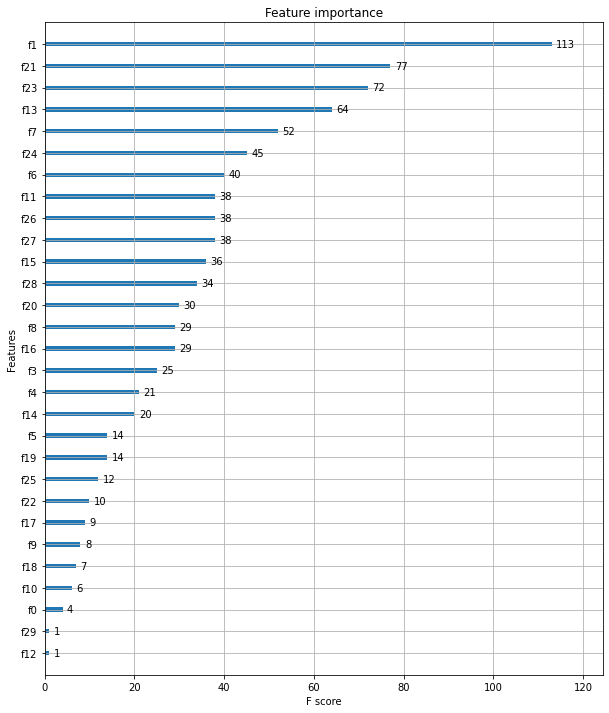

In [45]:
import matplotlib.pyplot as plt
% matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

#[실습] XGBoost using sklearn wrapper
- breast cancer dataset
- early stopping을 매우 작게 선택 할 경우, 충분한 학습이 되지않아 예측성능이 나빠질 수 있음

In [46]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_pred = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_pred, w_pred_proba)

오차행렬 
[[43  2]
 [ 0 69]]  
정확도 : 0.982 정밀도 :0.972 재현율 :1.000 f1 :0.986 auc:0.978


In [47]:
# early stopping을 적용해보자. (early_stopping_rounds=500)
xgb_wrapper= XGBClassifier(n_estimators=1000, learning_rate = 0.1, max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train, early_stopping_rounds=500, eval_metric='logloss', eval_set=evals , verbose=False)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

# early stopping을 적용해보자. (early_stopping_rounds=10)
xgb_wrapper.fit(X_train,y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals , verbose=False)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차행렬 
[[42  3]
 [ 2 67]]  
정확도 : 0.956 정밀도 :0.957 재현율 :0.971 f1 :0.964 auc:0.952
오차행렬 
[[42  3]
 [ 2 67]]  
정확도 : 0.956 정밀도 :0.957 재현율 :0.971 f1 :0.964 auc:0.952


##GridSearchCV를 통해 하이퍼파라미터를 구하고 학습후 예측하자.

In [53]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 모델 생성
xgb_model = XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보입력(어떤 모델, 파라미터 후보, 교차검증 몇번)
grid_cv = GridSearchCV(xgb_model,param_grid=params, cv=3)

# 파라미터 튜닝 시작
grid_cv_fit = grid_cv.fit(X_train,y_train,early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_test,y_test)],verbose=False)

# 최적 파라미터 출력
print(grid_cv_fit.best_params_)

# 튜닝된 파라미터를 가지고 모델 생성
xgb_model = XGBClassifier(n_estimator=1000, learning_rate=0.02,max_depth=7, colsample_bytree=0.5, min_child_weight=1)

# 학습 
xgb_model.fit(X_train, y_train)

# 예측
pred = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred,pred_proba)

{'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 1}
오차행렬 
[[43  2]
 [ 2 67]]  
정확도 : 0.965 정밀도 :0.971 재현율 :0.971 f1 :0.971 auc:0.963
